# P1: Redes Neuronales
## Construcción de un clasificador en PyTorch

 Esta práctica consistirá en implementar una red neuronal básica utilizando PyTorch para clasificar imágenes del conjunto de datos MNIST. MNIST es un conjunto de datos clásico que contiene imágenes de dígitos escritos a mano (0-9) en escala de grises de 28x28 píxeles. El objetivo es entrenar un clasificador que pueda predecir correctamente el dígito representado en cada imagen de entrada.

## Entorno
La siguiente celda importa las bibliotecas y módulos esenciales de PyTorch y torchvision necesarios para trabajar con redes neuronales, procesar datos y entrenar modelos.

In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Datos de entrada
El primer paso consistirá en preparar el conjunto de datos MNIST para entrenamiento y test.

1. **`transform = transforms.Compose([...])`**: Define una serie de transformaciones que se aplicarán a cada imagen de MNIST.
1. **`torchvision.datasets`**: torchvision proporciona una serie de conjuntos de datos ampliamente utilizados de forma nativa, como MNIST.
1. **`DataLoader`**: esta clase permitirá iterar sobre el conjunto de datos creado anteriormente (clase Dataset) tanto en el bucle de entrenamiento como en inferencia.
  1. Los DataLoaders para entrenamiento y test no reciben necesariamente los mismos argumentos.

In [4]:

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]) # Recuerda normalizar los datos de entrada

bs = 64  # batch size

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Modelo
Empezaremos con un clasificador sencillo que consistirá en un Perceptrón Multicapa (MLP), con la siguiente arquitectura:
1. Una capa oculta con 128 neuronas de salida.
2. Una capa con las salidas de clasificación finales (logits).

Deberéis decidir las dimensiones de entrada y salida restantes teneiendo en cuenta el problema de clasificación que estamos intentando resolver en MNIST.

In [6]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Capa oculta con 128 neuronas e imagenes de 28x28 pieles, son fully conected
        self.relu = nn.ReLU() #Usamos relu de funcion de activacion, que transforma valores negativos en 0 y deja los positivos igual.
        self.fc2 = nn.Linear(128, 10)  # Capa de salida con 10 clases, podriamos aplicar softmax pero ya lo hace crossentropy y no hace falta

    def forward(self, x):
        #x contiene varias imágenes aplanadas en vectores
        #Cada imagen (vector de 784 valores) pasa por una capa completamente conectada
        #y se transforma en un nuevo vector de 128 valores por imagen
        x = x.view(-1, 28 * 28)  # Aplanar la imagen (batch_size, 784), -1 significa que el tamaño del batch se ajusta automáticamente
        x = self.fc1(x) # se pasa cada batch por la primera capa, multiplica x por la matriz de pesos y le suma el sesgo
        x = self.relu(x) #se aplica relu, por ejemplo [-2, 3, -1, 5] pasaría a [ 0, 3,  0, 5] 
        x = self.fc2(x) #Genera valores que representan la probabilidad de cada clase antes de aplicarle softmax, el indice mas alto es la prediccion
        #el vector tendria esta forma  por ejemplo [2.3, -1.5, 0.8, 3.1, 2.9, -0.2, 1.7, 0.5, 0.1, -2.1]
        return x  # Logits sin activación final (se usará CrossEntropyLoss)

model = MNISTClassifier()
print(model)    

MNISTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Inicialización
A continuación instanciaremos el modelo y el optimizador, podéis hacer varias pruebas variando el learning rate y utilizando diferentes optimizadores. El optimizador será el encargado de actualizar los pesos del modelo en cada iteración de entrenamiento minimizando la función de coste. Utilizaremos una tasa de aprendizaje constante a lo largo de todo el entrenamiento.

Pruebas con optimizadores:
  1. Utilizando descenso de gradiente estocástico:
    1. Realizar diferentes pruebas de tasa de aprendizaje.
  1. Utilizar descenso de gradiente estocástico con decaimiento de pesos y "*momentum*".
  1. Utilizar Adam como optimizador.

Debes decidir una función de coste acorde al problema que estamos tratando.

In [8]:
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss() #funcion de coste, entropia cruzada, hay que pasarle las Z solo, porque la funcion de cross entropy de pytorch ya aplica softmax

In [9]:
#Las pruebas con diferentes hiperparámetros van debajo, no es necesario ejecutar estas 4 celdas, pero se pueden ejecutar para probar
learning_rate=0.01 

In [10]:
#Opción 1
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # probar LR al menos en el rango 0.5 overfitting 0.0001

In [11]:
#Opción 2
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)


In [12]:
#Opción 3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Bucle de entrenamiento
La siguiente función proporciona el esqueleto básico de un bucle de entrenamiento en PyTorch.
Presta especial atención al funcionamiento de las siguientes secuencias:
- Forward:

      outputs = model(images)
      loss = criterion(outputs, labels)
- Backward:

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


Se deben almacenar el valor de la función de coste de entrenamiento cada 100 iteraciones. Además, después de cada época, se debe calcular el coste sobre el conjunto de validación.


In [15]:
#el loss (pérdida) de validación es la pérdida calculada sobre el conjunto de datos de validación después de cada época de entrenamiento
#las epocas son el número de veces que el modelo procesa todo el conjunto de datos de entrenamiento

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    train_losses = [] # Lista para almacenar el loss de entrenamiento en cada época
    val_losses = []   
    
    for epoch in range(epochs):
        model.train() # Poner el modelo en 'modo' entrenamiento
        running_loss = 0.0 # Acumulador para la pérdida en esta época
        
        for images, labels in train_loader:
            optimizer.zero_grad() #resetear los gradientes acumulados
            outputs = model(images) #hace el forward y obtiene predicciones
            loss = criterion(outputs, labels)
            loss.backward() #hace backpropagation para calcular gradientes
            optimizer.step() #actualizamos los pesos
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        model.eval() # Ponemos el modelo en modo evaluacion
        val_loss = 0.0
        with torch.no_grad():  #No calcular gradientes durante validación
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoca {epoch+1}/{epochs} - Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses




train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

Epoca 1/5 - Loss: 0.3780 - Validation Loss: 0.2634
Epoca 2/5 - Loss: 0.2606 - Validation Loss: 0.2847
Epoca 3/5 - Loss: 0.2402 - Validation Loss: 0.2575
Epoca 4/5 - Loss: 0.2273 - Validation Loss: 0.2300
Epoca 5/5 - Loss: 0.2154 - Validation Loss: 0.2600


In [16]:
def plot_losses(train_losses, val_losses,opti,lr): #funcion para dibujar el loss
    plt.figure(figsize=(8, 5))
    epochs = range(1, len(train_losses) + 1)  # Comienza en 1
    plt.plot(epochs,train_losses, label='Loss de entrenamiento')
    plt.plot(epochs,val_losses, label='Loss de validacion')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Gráfica de loss con opti {opti} y lr {lr}')
    plt.show()

## Sacar gráficas de loss para diferentes LR y diferentes optimizadores
Representar en una misma gráfica la evolución del coste del entrenamiento y del coste de validación calculado en cada época.

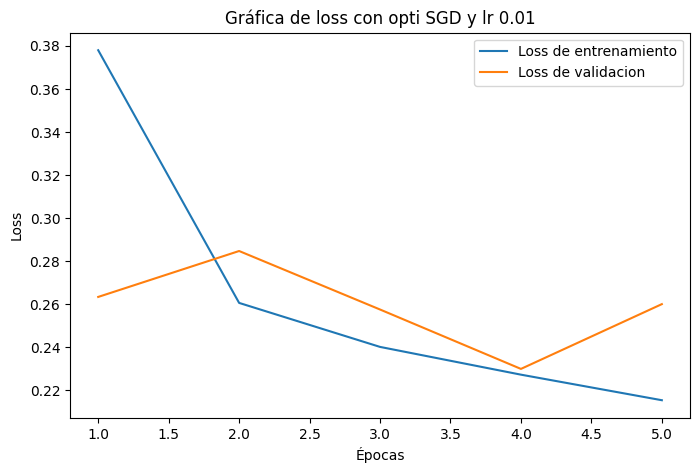

In [18]:
plot_losses(train_losses, val_losses,"SGD",learning_rate)


Entrenando con SGD y LR=0.5
Epoca 1/5 - Loss: 2.3146 - Validation Loss: 2.3023
Epoca 2/5 - Loss: 2.3030 - Validation Loss: 2.3045
Epoca 3/5 - Loss: 2.3032 - Validation Loss: 2.2969
Epoca 4/5 - Loss: 2.3032 - Validation Loss: 2.3022
Epoca 5/5 - Loss: 2.3032 - Validation Loss: 2.3042


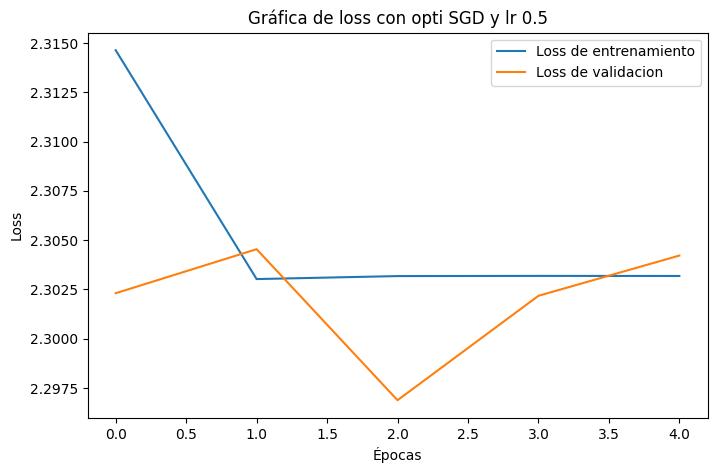


Entrenando con SGD y LR=0.1
Epoca 1/5 - Loss: 0.4009 - Validation Loss: 0.3035
Epoca 2/5 - Loss: 0.1775 - Validation Loss: 0.1699
Epoca 3/5 - Loss: 0.1327 - Validation Loss: 0.2061


KeyboardInterrupt: 

In [63]:
#Para hacer distintas pruebas con  learning rates y optimizadores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]
optimizadores = ['SGD', 'SGD_momentum', 'Adam']

#tarda un ratillo
for opti in optimizadores:
    for lr in learning_rates:
        model = MNISTClassifier().to(device)
        criterion = nn.CrossEntropyLoss()
        
        if opti == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif opti == 'SGD_momentum':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4) #dijo que tampoco probar una validacion con todos los parametros de momentum, que no hace falta
        elif opti == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        
        print(f"\nEntrenando con {opti} y LR={lr}")
        train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

        # Llamar a la función para graficar cada prueba por separado
        plot_losses(train_losses, val_losses,opti,lr)
        


## Inferencia
Función que implementa la inferencia del modelo en el conjunto de test.
Se espera un valor de Accuracy superior al 90%.

In [45]:
def evaluate_model(model, test_loader):
    model.eval()  #poner modo evaluación (desactiva dropout y batchnorm)
    correct = 0  #contador de predicciones correctas
    total = 0  #contador del total de ejemplos

    with torch.no_grad():  #no se calculan gradientes en inferencia
        for images, labels in test_loader:
            outputs = model(images) 
            _, predicted = torch.max(outputs, 1)  #obtener la clase con mayor probabilidad
            total += labels.size(0)  #sumar el total de muestras
            correct += (predicted == labels).sum().item()  #contar aciertos

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy  

evaluate_model(model, test_loader)

Test Accuracy: 97.28%


97.28

## Cálculo de loss

Vamos a calcular el loss para el primer batch del conjunto de datos de entrenamiento. Para ello recuerda convertir las etiquetas a "one hot". Una vez tengas el loss calculado comprueba que coincide con el calculado por "criterion".

En PyTorch podemos acceder a los gradientes asociados a unos pesos w a través de *w.grad*. Accede a los gradientes calculados para los pesos de la primera capa y calcula manualmente como sería el valor de los pesos tras el backward. Comprueba que los resultados calculados manualmente coinciden con los pesos una vez realizada una iteración completa de entrenamiento.

Para este ejercicio utiliza descenso de gradiente estocástico sin decaimiento de pesos ni *momentum*.

In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
model = MNISTClassifier()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Sin momentum ni weight decay
outputs = model(images)

# Calcular loss utilizando criterion
loss = criterion(outputs, labels)
print(f"Loss con criterion: {loss.item():.6f}")


# Calcular loss "manualmente"
softmax = torch.nn.functional.softmax(outputs, dim=1)  # Aplicar softmax  para obtener probabilidades de los logits
log_softmax = torch.log(softmax)  # Logaritmo de softmax
etiquetas_one_hot = torch.nn.functional.one_hot(labels, num_classes=10)  # Convertir etiquetas a one-hot
loss_manual = -(etiquetas_one_hot * log_softmax).sum(dim=1).mean()  # Cross-Entropy manual
print(f"Loss calculado manualmente: {loss_manual.item():.6f}")

loss.backward()

# Calcular como se actualizarían los pesos de la primera capa
pesos_primera_capa = model.fc1.weight
gradientes_primera_capa = pesos_primera_capa.grad
print(f"Gradientes de la primera capa:\n {gradientes_primera_capa}")

learning_rate = 0.01
nuevos_pesos = pesos_primera_capa - learning_rate * gradientes_primera_capa

# Realizar iteración de entrenamiento actualizando pesos
optimizer.step() 

print(f"Diferencia entre pesos actualizados manualmente y con optimizer:\n"
      f"{torch.norm(nuevos_pesos - model.fc1.weight).item():.6f}")

Loss con criterion: 2.339923
Loss calculado manualmente: 2.339923
Gradientes de la primera capa:
 tensor([[ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [ 0.0035,  0.0035,  0.0035,  ...,  0.0035,  0.0035,  0.0035],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0035, -0.0035, -0.0035,  ..., -0.0035, -0.0035, -0.0035],
        [ 0.0057,  0.0057,  0.0057,  ...,  0.0057,  0.0057,  0.0057]])
Diferencia entre pesos actualizados manualmente y con optimizer:
0.000000


## Visualización
1. Visualiza las imágenes contenidas en un batch.
1. Muestra el Ground Truth para cada una de ellas y la predicción del modelo.

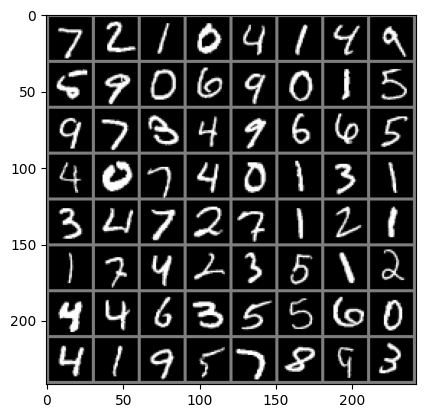

Las etiquetas de las imagenenes son:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
Las predicciones que realiza el modelo son:  tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [49]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() #pasa el tensor a array de numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #En PyTorch las imágenes tienen la forma Canales, Altura, Anchura) y matplotlib las espera como (Altura, Achura, Canales)
    plt.show()

iterador = iter(test_loader) #test loader tiene una tupla con el tensor y la etiqueta por cada imagen
images, labels = next(iterador) #iteras una vez y recoges las imagenes y las etiquetas de un batch entero


imshow(torchvision.utils.make_grid(images))
print('Las etiquetas de las imagenenes son: ',labels)
outputs=model(images)
_,predicciones=torch.max(outputs, 1)
print('Las predicciones que realiza el modelo son: ',predicciones)

## Probabilidad para un ejemplo dado
1. Para cada ejemplo en el batch, además de calcular la clase predicha calcula también la probabilidad de dicha clase.

In [52]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([13.9326, 13.7911,  7.8466, 10.0953,  9.3385, 10.5410, 10.7961,  8.5955,
         7.4741, 10.0887, 15.6008,  9.7055, 11.3671, 14.1619, 12.9003, 11.2487,
        11.5243, 15.2467,  6.7666, 10.9779, 12.2844,  9.8721,  9.7894, 15.4859,
         7.9585, 15.9061, 11.5367, 13.1431, 16.5533,  9.7496, 13.0222,  8.1870,
        14.0396,  9.3423, 13.8197, 10.5275, 12.9240, 11.0497,  8.9409, 10.8203,
         7.6817, 11.7052, 11.1282, 11.3989,  9.4264, 11.9691,  9.9298, 10.1928,
        15.8915, 11.2452,  9.4673,  9.7012, 11.3081, 10.0801, 12.2001, 11.3644,
        13.4582,  8.8344, 11.8323, 10.5597, 12.8567,  9.9194,  6.5986,  7.6651],
       grad_fn=<MaxBackward0>),
indices=tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3]))

In [58]:
import torch.nn.functional as F
# Calcular probabilidades aplicando softmax
probabilidades = F.softmax(outputs, dim=1)

# Mostrar las probabilidades del primer ejemplo del batch
for indice in range(len(images)):
    print(f"\nImagen {indice+1}")
    for i, prob in enumerate(probabilidades[indice]):
        print(f"Clase {i}: {prob.item():.4f}")


Imagen 1
Clase 0: 0.0000
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0003
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.9997
Clase 8: 0.0000
Clase 9: 0.0000

Imagen 2
Clase 0: 0.0000
Clase 1: 0.0001
Clase 2: 0.9997
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0001
Clase 6: 0.0001
Clase 7: 0.0000
Clase 8: 0.0000
Clase 9: 0.0000

Imagen 3
Clase 0: 0.0000
Clase 1: 0.9948
Clase 2: 0.0019
Clase 3: 0.0001
Clase 4: 0.0003
Clase 5: 0.0007
Clase 6: 0.0007
Clase 7: 0.0005
Clase 8: 0.0009
Clase 9: 0.0000

Imagen 4
Clase 0: 0.9995
Clase 1: 0.0000
Clase 2: 0.0002
Clase 3: 0.0000
Clase 4: 0.0000
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0002
Clase 8: 0.0000
Clase 9: 0.0001

Imagen 5
Clase 0: 0.0001
Clase 1: 0.0000
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.9874
Clase 5: 0.0000
Clase 6: 0.0001
Clase 7: 0.0019
Clase 8: 0.0000
Clase 9: 0.0104

Imagen 6
Clase 0: 0.0000
Clase 1: 0.9986
Clase 2: 0.0000
Clase 3: 0.0000
Clase 4: 0.0001
Clase 5: 0.0000
Clase 6: 0.0000
Clase 7: 0.0012
Clase 8: 0.0